In [2]:
#Adapted from Chap 6
#also could be useful
#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

In [1]:
import torch
import json
import random as ra
import numpy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

exec(open("01-utilities.py").read())
exec(open("05-utilities.py").read())


import sentencepiece as spm

import torch
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn

#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
import sklearn.metrics as metrics

In [6]:
#load data
def get_segments(name):
    #filename= './'+name+'_LSTM_DATA.json'
    #segments = json.load(open('./LSTM_DATA.json'))
    
    segments = json.load(open('./'+name+'_LSTM_DATA.json'))

    #print data info
    print('number of code snippet samples:',len(segments))
    #total samples wtihin snippets
    count = 0
    #find number of samples in a snippet
    for s in segments:
        count+=len(segments[s]['x'])

    print('number of total samples from parsed snippets:',count)
    
    return segments


###???
#l = np.random.choice(range(0,100),4)
#l[0] in l


'''
def get_sampled_indexes(segment_length,num,frac=False):
    if frac:
        sampled_indexes = np.random.choice(range(0,segment_length),int(segment_length/num))
    else:
        sampled_indexes = np.random.choice(range(0,segment_length),num)
        
    return sampled_indexes
'''
def get_sampled_indexes(segment_length,num,frac=False):
    if frac:
        sampled_indexes = ra.sample(range(0,segment_length),int(segment_length/num))
    else:
        sampled_indexes = ra.sample(range(0,segment_length),num)
        
    return sampled_indexes




#split the data

#'''

def get_samples(segments, num_train, num_val, num_test, mult = 1 ):
    
    #multi serves to increase the number of samples and number sampled from data
    
    
    train_x=[]
    train_y=[]
    val_x = []
    val_y = []
    test_x = []
    test_y = []

    for s in segments:


        #only use X amount of data from each segment
        #to reduce data size and train on more samples (so more representive of whole data set)
        segment_length = len(segments[s]['x'])
        sampled_indexes = get_sampled_indexes(segment_length,mult)

        for ix,x in enumerate(segments[s]['x']):

            y = segments[s]['y'][ix]

            #must be of correct shape to be used
            if len(x)==41 and len(y)==41 and ix in sampled_indexes: #and 1 in y:
                if len(train_x)<num_train*mult:
                    train_x.append(x)
                    train_y.append(y)
                elif len(val_x)<num_val*mult:
                    val_x.append(x)
                    val_y.append(y)
                elif len(test_x)<num_test*mult:
                    test_x.append(x)
                    test_y.append(y)
                else:
                    #extra data
                    pass
                
    return train_x, train_y, val_x, val_y, test_x, test_y
#'''

class code_snippet_loader(torch.utils.data.Dataset):
    """
    A PyTorch Dataset wrapper for the code segmentation dataset as an LM!
    """
    def __init__(self,x,y):
        # set up our data containers 
        # note: we will be creating a list of tensors
        self.x = torch.LongTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        # the length of our dataset is simply 
        # the number of samples!
        return len(self.x)

    def __getitem__(self, item):
        # when calling a specific example,
        # we return the input, which is also the gold label!
        return {'x': self.x[item],
                'y': self.y[item]}
    
def train_lm(model, train_data, val_data, 
             word_vectors, num_train, num_val, name,
             batch_size=50, lr=0.01, mu=0.25):
    # setup our optimizer and loss function
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    #loss_fn = nn.CrossEntropyLoss(reduction='sum')

    torch.manual_seed(691)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    epoch = 0
    no_imp = 0
    patience=5
    
    # max_epoch turns off early stopping, when set
    max_epochs = 250 #100 #50
    training = True
    best_val_loss = None
    
    history = {}
    
    training=True

    #while (training and not max_epoch) or (epoch < max_epoch):
    #while training and epoch < max_epoch:
    while epoch < max_epochs and no_imp < patience:
        print(f'Start epoch {epoch + 1}')

        # Turn on training mode which enables dropout.
        model.train()
        train_loss = 0
        vocab_size = word_vectors.shape[0]
        #print('----')

        for i, batch in enumerate(train_loader):
            ###
            ###MAKE SOME PRINTOUTS
            ###
            # clear any remaining gradients
            model.zero_grad()
            
            # forward pass
            y_preds, h = model(to_gpu(batch['x']))
            

            # calculate loss
            loss = loss_fn(y_preds.view(-1), to_gpu(batch['y'].view(-1)))
            train_loss += loss.cpu().item()
            #print(train_loss)
            
            # Calculate the gradients
            loss.backward()
        
            # `clip_grad_norm` applies gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), mu)

            # update the parameteres yet after clipping
            opt.step()

        print(f'Current train loss: {train_loss:.2f}')
        print(f'Average per sample train loss: {(train_loss/num_train):.2f}')

        # disable gradients during validation
        model.eval()

        val_loss = 0
        for batch in val_loader:
            y_preds, h = model(to_gpu(batch['x']))
            val_loss += loss_fn(y_preds.view(-1), to_gpu(batch['y'].view(-1))).cpu().item()

        print(f'Total validation loss: {val_loss:.2f}')
        print(f'Average per sample validation loss: {(val_loss/num_val):.2f}')
        
        if best_val_loss is None or val_loss < best_val_loss:
            best_val_loss = val_loss
            no_imp = 0
            torch.save(model.state_dict(), './data/'+name+'biLSTM_LM.pt')
        else:
            no_imp += 1

        print(f'Best validation loss: {best_val_loss:.2f} (Epochs without improvement: {no_imp})')
        
        '''
        if not best_val_loss:
            best_val_loss = val_loss
        elif val_loss < best_val_loss:
            best_val_loss = val_loss
        else:
            print('No improvement! Early stopping')
            training = False
        '''

    
        epoch += 1
        
        history['epoch_'+str(epoch)]={'train_loss':train_loss,'val_loss':val_loss}
        print()

    return model,history


###
# adapted from the PyTorch examples. for the full PyTorch LM example, see: 
# https://github.com/pytorch/examples/blob/master/word_language_model/model.py
###

class LSTM_LM(nn.Module):
    """Model feeds pre-trained embeddings through a series of biLSTM
       layers, followed by a linear vocabulary decoder."""
    
    def __init__(self, in_dim, hidden_dim, lstm_layers, word_vectors, 
                 dropout=0.05, bidirectional = True):
        super(LSTM_LM, self).__init__()

        self.vocab_size = word_vectors.shape[0]
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers

        # blank embed layer starting from GloVe pre-trained vectors
        self._embed = nn.Embedding.from_pretrained(word_vectors, freeze=False)        
        self._drop = nn.Dropout(dropout)

        self._lstm = nn.LSTM(in_dim, hidden_dim, num_layers = lstm_layers, dropout = dropout,
                             bidirectional = bidirectional, batch_first=True)
        self._ReLU = nn.ReLU()
        self._pred = nn.Linear((2 if bidirectional else 1)*hidden_dim, 
                               #self.vocab_size)
                               1) #only 1 or zeros here 

    def forward(self, x):
        e = self._drop(self._embed(x))
        z, h = self._lstm(e)
        z_drop = self._drop(z)
        s = self._pred(self._ReLU(z_drop))
        #s = s.view(-1, self.vocab_size)
        s = s.squeeze()
        return s, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.lstm_layers, batch_size, self.hidden_dim)
    
    


In [4]:
def train_code_segmentation_model(name):
    
    #add name param
    segments = get_segments(name)

    num_train = 5000
    num_val   = 1500
    num_test  = 1500

    #split data
    train_x, train_y, val_x, val_y, test_x, test_y = get_samples(segments, num_train, num_val, num_test)


    print('Data Set Up')
    print('number of training samples:',len(train_x))
    print('number of validation samples:',len(val_x))
    print('number of testing samples:',len(test_x))

    LM_train_loader = code_snippet_loader(train_x, train_y)
    LM_val_loader = code_snippet_loader(val_x, val_y)
    LM_test_loader = code_snippet_loader(test_x, test_y)

    # considering what our new input, target pairs look like:
    print(len(LM_train_loader.x), LM_train_loader[3])


    torch.manual_seed(691)

    #vocab size from sentence peice
    #vocab dim???? 
    vocab_size = 10000 #same as sentence peice
    vocab_dim = 50  # the size of our pre-trained word vectors

    # randomly initialize our word vectors!
    vocab_dim = 256
    word_vectors = torch.randn(vocab_size, vocab_dim)
    word_vectors.shape, word_vectors

    #show model
    hidden_dim = 200
    lstm_layers = 2
    #LSTM_LM_net = to_gpu(LSTM_LM(newstweet_wvs.shape[1], hidden_dim,lstm_layers, newstweet_wvs))
    LSTM_LM_net = LSTM_LM(word_vectors.shape[1], hidden_dim,lstm_layers, word_vectors)

    LSTM_LM_net

    # Train model

    #batch_size = 50 
    batch_size = 50

    # an initial learning rate, prior to clipping
    lr = 0.0005
    #lr = 0.01

    # the clipping theshold
    mu = 0.25

    LSTM_LM_net_trained, history = train_lm(LSTM_LM_net, LM_train_loader, LM_val_loader, 
                                            word_vectors, num_train, num_val, name,
                                            batch_size=batch_size, lr=lr, mu=mu)


    #show 

    training_loss_values = []
    validation_loss_values = []
    for loss in history:

        #normal
        #training_loss_values.append(history[loss]['train_loss'])
        #validation_loss_values.append(history[loss]['val_loss'])
        #
        #adjusted normal
        training_loss_values.append(history[loss]['train_loss']/num_train)
        validation_loss_values.append(history[loss]['val_loss']/num_val)
        #
        #log
        #training_loss_values.append(np.log(history[loss]['train_loss']))
        #validation_loss_values.append(np.log(history[loss]['val_loss']))
        #
        #adjusted log
        #training_loss_values.append(np.log(history[loss]['train_loss']/num_train))
        #validation_loss_values.append(np.log(history[loss]['val_loss']/num_val))


    Epochs = range(len(training_loss_values))


    #show all
    plt.plot(Epochs, training_loss_values)
    plt.plot(Epochs, validation_loss_values)
    #show all but the first one
    #plt.plot(Epochs[1:], training_loss_values[1:])
    #plt.plot(Epochs[1:], validation_loss_values[1:])
    plt.title('Average loss per sample')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    
    test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)
    
    
    #SHOW RESUTLS on all Tokens
    # calculate the fpr and tpr for all thresholds of the classification
    for batch in test_loader:

        #get predicted values
        y_preds, h = LSTM_LM_net_trained(batch['x'])
        y_preds = torch.flatten(torch.sigmoid(y_preds))
        y_preds= y_preds.detach().numpy()

        #get true values
        y = batch['y'].view(-1)
        y = y.detach().numpy()

        #accuracy
        acc = metrics.accuracy_score(y, numpy.rint(y_preds))

        # Compute ROC curve and ROC area for each class
        fpr, tpr, threshold = metrics.roc_curve(y, y_preds)

        roc_auc = metrics.auc(fpr, tpr)


    print('Accuracy:',acc)
    print('Area under curve:',roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) on Test Set')
    plt.legend(loc="lower right")
    plt.show()
    
    #instantiate tokenizer model
    
    class Tokenizer:
    
        def __init__(self, filepath=name+'_tokenizer.model'):
            self.sp = spm.SentencePieceProcessor(model_file=filepath)

        def encode(self, text, t=int):
            return self.sp.encode(text, out_type=t)

        def decode(self, pieces):
            return self.sp.decode(pieces)

        @staticmethod
        def train(input_file='data/raw_sents.txt', model_prefix='sp_model', vocab_size=30522):
            spm.SentencePieceTrainer.train(input=input_file, model_prefix=model_prefix, vocab_size=vocab_size,
                                           #input_sentence_size=2 ** 16, shuffle_input_sentence=True)
                                           input_sentence_size=number_of_lines, shuffle_input_sentence=True)

    
    tokenizer = Tokenizer(name+'_tokenizer.model')
    
    
    #make a _NEW_LINE_ ROC curve since thats what we care about
    test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)

    # calculate the fpr and tpr for all thresholds of the classification
    for batch in test_loader:

        #get predicted values
        y_preds, h = LSTM_LM_net_trained(batch['x'])
        y_preds = torch.flatten(torch.sigmoid(y_preds))
        y_preds= y_preds.detach().numpy()

        #get true values
        y = batch['y'].view(-1)
        y = y.detach().numpy()

        #filter for only new line places (get info from batch['x'])
        new_y=[]
        new_y_preds=[]
        tokens = torch.flatten(batch['x']).detach().numpy()
        for i in range(len(tokens)):
            tok_literal=tokenizer.decode(int(tokens[i]))
            if tok_literal[-7:]=='NEWLINE':
                #only rate actual break places
                #if y[i]==1:
                #    new_y.append(y[i])
                #    new_y_preds.append(y_preds[i])
                new_y.append(y[i])
                new_y_preds.append(y_preds[i])
        #accuracy
        #https://numpy.org/doc/stable/reference/generated/numpy.rint.html
        acc = metrics.accuracy_score(new_y, numpy.rint(new_y_preds))

        # Compute ROC curve and ROC area for each class
        fpr, tpr, threshold = metrics.roc_curve(new_y, new_y_preds)

        roc_auc = metrics.auc(fpr, tpr)

    print('Accuracy:',acc)
    print('Area under curve:',roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) on Test Set')
    plt.legend(loc="lower right")
    plt.show()
        
#train_code_segmentation_model('py')

--------------------------------------------------
trianing... py short
--------------------------------------------------
number of code snippet samples: 10000
number of total samples from parsed snippets: 2077520
Data Set Up
number of training samples: 5000
number of validation samples: 1500
number of testing samples: 1500
5000 {'x': tensor([  3,   3,   3,  11,   3,   5,   5,  63,  29,   6,  10,   3,  93,   3,
         14,   3, 734,   9,   4,   3,   3,   3,   3,   3,   3,   3,   3,   6,
          8,  93,   3,  14,   3, 271,   8, 271,   7,  93,  13,   4,   4]), 'y': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Start epoch 1
Current train loss: 22709.63
Average per sample train loss: 4.54
Total validation loss: 2442.28
Average per sample validation loss: 1.63
Best validation loss: 2442.28 (Epochs without improvement: 0)

Start epoch 2
Current train lo

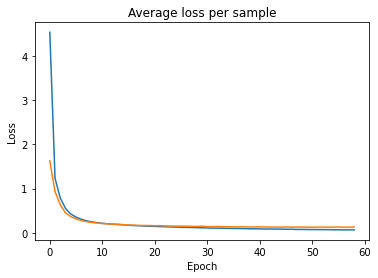

Accuracy: 0.9991056910569106
Area under curve: 0.9998932887852138


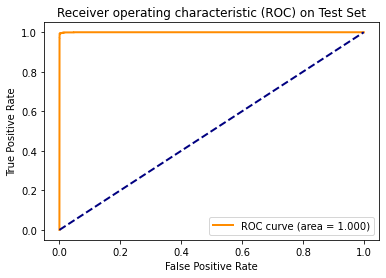

Accuracy: 0.9902477082114297
Area under curve: 0.9990625791740563


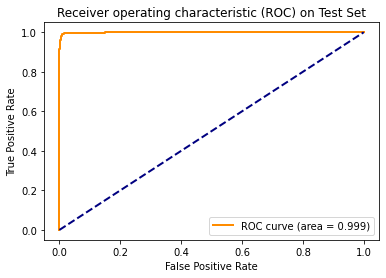

--------------------------------------------------
trianing... py medium
--------------------------------------------------
number of code snippet samples: 10000
number of total samples from parsed snippets: 3949174
Data Set Up
number of training samples: 5000
number of validation samples: 1500
number of testing samples: 1500
5000 {'x': tensor([   3,    3,   14,    3,   19,    5,  890,    7,    8,    9,    3,  173,
           5, 3413,   11,   77,   10,    4,    3,    3,    3,    3,    3,    3,
           3,    3,    4,    4,    3,    3,    3,    3,    3,    3,    3,   13,
           3,    7,    8,    6,  890]), 'y': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Start epoch 1
Current train loss: 18594.73
Average per sample train loss: 3.72
Total validation loss: 1700.24
Average per sample validation loss: 1.13
Best validation loss: 1700.24 (Epochs witho

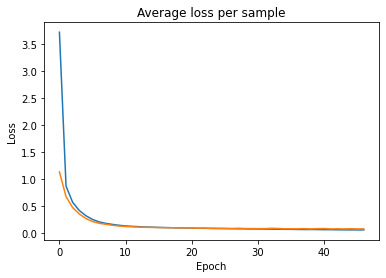

Accuracy: 0.999349593495935
Area under curve: 0.9999477191626059


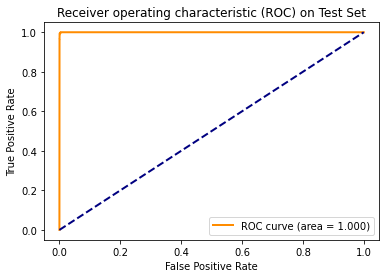

Accuracy: 0.9905638122198632
Area under curve: 0.999164851831687


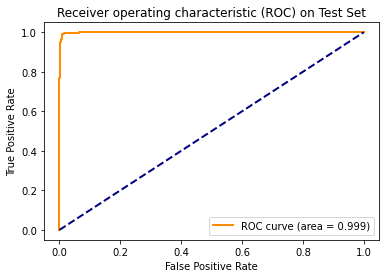

--------------------------------------------------
trianing... py long
--------------------------------------------------
number of code snippet samples: 10000
number of total samples from parsed snippets: 9659283
Data Set Up
number of training samples: 5000
number of validation samples: 1500
number of testing samples: 1500
5000 {'x': tensor([   3,    3,    3,    3, 4311,    3,    8,    3,    7,    4,    3,    3,
           3,    3,    3,    3,    3,    3,   19,  293,    3, 1218,    3,   48,
           3, 1372,  692,    3, 4432,    3,  170, 2440,   46,  122,   46,   19,
           4,    3,    3,    3,    3]), 'y': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
Start epoch 1
Current train loss: 14066.66
Average per sample train loss: 2.81
Total validation loss: 954.74
Average per sample validation loss: 0.64
Best validation loss: 954.74 (Epochs without i

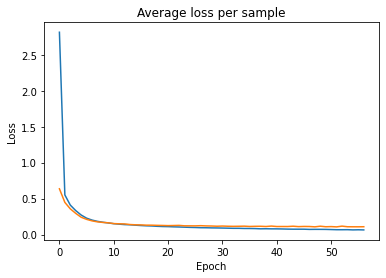

Accuracy: 0.9990731707317073
Area under curve: 0.9967068013129331


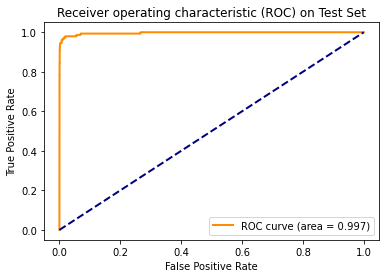

Accuracy: 0.9855892949047864
Area under curve: 0.9860339901838693


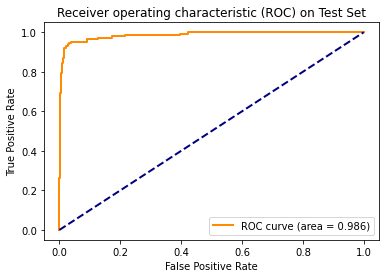

In [7]:
#single language, all sizes
#'''
for i in ['py']:#,'cpp','java']:
    for j in ['short','medium','long']:
        print('--------------------------------------------------')
        print('trianing...',i,j)
        print('--------------------------------------------------')
        name = j+'_'+i
        train_code_segmentation_model(name)
#'''

In [34]:
#saving the biLSTM's weights
# ...we now have save best in training
#torch.save(LSTM_LM_net_trained.state_dict(), './data/biLSTM_LM.pt')

# TODO FIX TO WORK FOR LONG SHORT AND MEDIUM

In [ ]:
def train_multilingual_code_segmentation_model(size):
    
    
    name = size+'_all'
    num_train = 1500
    num_val   = 500
    num_test  = 500
    
    
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    
    languages = ['py','cpp','java']
    for l in languages:
        segments = get_segments(size+'_'+l)
        #split data
        train_x_temp, train_y_temp, val_x_temp, val_y_temp, test_x_temp, test_y_temp = get_samples(segments, num_train, num_val, num_test)
        
        train_x+=train_x_temp
        train_y+=train_y_temp
        val_x+=val_x_temp
        val_y+=val_y_temp
        test_x+=test_x_temp
        test_y+=test_y_temp
        
        


    print('Data Set Up')
    print('number of training samples:',len(train_x))
    print('number of validation samples:',len(val_x))
    print('number of testing samples:',len(test_x))

    LM_train_loader = code_snippet_loader(train_x, train_y)
    LM_val_loader = code_snippet_loader(val_x, val_y)
    LM_test_loader = code_snippet_loader(test_x, test_y)

    # considering what our new input, target pairs look like:
    print(len(LM_train_loader.x), LM_train_loader[3])


    torch.manual_seed(691)

    #vocab size from sentence peice
    #vocab dim???? 
    vocab_size = 10000 #same as sentence peice
    vocab_dim = 50  # the size of our pre-trained word vectors

    # randomly initialize our word vectors!
    vocab_dim = 256
    word_vectors = torch.randn(vocab_size, vocab_dim)
    word_vectors.shape, word_vectors

    #show model
    hidden_dim = 200
    lstm_layers = 2
    #LSTM_LM_net = to_gpu(LSTM_LM(newstweet_wvs.shape[1], hidden_dim,lstm_layers, newstweet_wvs))
    LSTM_LM_net = LSTM_LM(word_vectors.shape[1], hidden_dim,lstm_layers, word_vectors)

    LSTM_LM_net

    # Train model

    #batch_size = 50 
    batch_size = 50

    # an initial learning rate, prior to clipping
    lr = 0.0005
    #lr = 0.01

    # the clipping theshold
    mu = 0.25

    LSTM_LM_net_trained, history = train_lm(LSTM_LM_net, LM_train_loader, LM_val_loader, 
                                            word_vectors, num_train, num_val, name,
                                            batch_size=batch_size, lr=lr, mu=mu)


    #show 

    training_loss_values = []
    validation_loss_values = []
    for loss in history:

        #normal
        #training_loss_values.append(history[loss]['train_loss'])
        #validation_loss_values.append(history[loss]['val_loss'])
        #
        #adjusted normal
        training_loss_values.append(history[loss]['train_loss']/num_train)
        validation_loss_values.append(history[loss]['val_loss']/num_val)
        #
        #log
        #training_loss_values.append(np.log(history[loss]['train_loss']))
        #validation_loss_values.append(np.log(history[loss]['val_loss']))
        #
        #adjusted log
        #training_loss_values.append(np.log(history[loss]['train_loss']/num_train))
        #validation_loss_values.append(np.log(history[loss]['val_loss']/num_val))


    Epochs = range(len(training_loss_values))


    #show all
    plt.plot(Epochs, training_loss_values)
    plt.plot(Epochs, validation_loss_values)
    #show all but the first one
    #plt.plot(Epochs[1:], training_loss_values[1:])
    #plt.plot(Epochs[1:], validation_loss_values[1:])
    plt.title('Average loss per sample')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    
    test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)
    
    
    #SHOW RESUTLS on all Tokens
    # calculate the fpr and tpr for all thresholds of the classification
    for batch in test_loader:

        #get predicted values
        y_preds, h = LSTM_LM_net_trained(batch['x'])
        y_preds = torch.flatten(torch.sigmoid(y_preds))
        y_preds= y_preds.detach().numpy()

        #get true values
        y = batch['y'].view(-1)
        y = y.detach().numpy()

        #accuracy
        acc = metrics.accuracy_score(y, numpy.rint(y_preds))

        # Compute ROC curve and ROC area for each class
        fpr, tpr, threshold = metrics.roc_curve(y, y_preds)

        roc_auc = metrics.auc(fpr, tpr)


    print('Accuracy:',acc)
    print('Area under curve:',roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) on Test Set')
    plt.legend(loc="lower right")
    plt.show()
    
    #instantiate tokenizer model
    
    class Tokenizer:
    
        def __init__(self, filepath=name+'_tokenizer.model'):
            self.sp = spm.SentencePieceProcessor(model_file=filepath)

        def encode(self, text, t=int):
            return self.sp.encode(text, out_type=t)

        def decode(self, pieces):
            return self.sp.decode(pieces)

        @staticmethod
        def train(input_file='data/raw_sents.txt', model_prefix='sp_model', vocab_size=30522):
            spm.SentencePieceTrainer.train(input=input_file, model_prefix=model_prefix, vocab_size=vocab_size,
                                           #input_sentence_size=2 ** 16, shuffle_input_sentence=True)
                                           input_sentence_size=number_of_lines, shuffle_input_sentence=True)

    
    tokenizer = Tokenizer(name+'_tokenizer.model')
    
    
    #make a _NEW_LINE_ ROC curve since thats what we care about
    test_loader = torch.utils.data.DataLoader(LM_test_loader, batch_size=num_test, shuffle=True)

    # calculate the fpr and tpr for all thresholds of the classification
    for batch in test_loader:

        #get predicted values
        y_preds, h = LSTM_LM_net_trained(batch['x'])
        y_preds = torch.flatten(torch.sigmoid(y_preds))
        y_preds= y_preds.detach().numpy()

        #get true values
        y = batch['y'].view(-1)
        y = y.detach().numpy()

        #filter for only new line places (get info from batch['x'])
        new_y=[]
        new_y_preds=[]
        tokens = torch.flatten(batch['x']).detach().numpy()
        for i in range(len(tokens)):
            tok_literal=tokenizer.decode(int(tokens[i]))
            if tok_literal[-7:]=='NEWLINE':
                #only rate actual break places
                #if y[i]==1:
                #    new_y.append(y[i])
                #    new_y_preds.append(y_preds[i])
                new_y.append(y[i])
                new_y_preds.append(y_preds[i])
        #accuracy
        #https://numpy.org/doc/stable/reference/generated/numpy.rint.html
        acc = metrics.accuracy_score(new_y, numpy.rint(new_y_preds))

        # Compute ROC curve and ROC area for each class
        fpr, tpr, threshold = metrics.roc_curve(new_y, new_y_preds)

        roc_auc = metrics.auc(fpr, tpr)

    print('Accuracy:',acc)
    print('Area under curve:',roc_auc)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) on Test Set')
    plt.legend(loc="lower right")
    plt.show()

for s in ['short','medium','long']:
    train_multilingual_code_segmentation_model(s)